# 🚫🧟 StopSlop

The objective of this notebook is to create a system to identify slop websites.
The system should be fast, adaptable to js and non-reliable on external libraries. Because of that, the approach will be:
1. Create a slop vs non-slop dataset with web scrapping
2. Identify interesting features that can be ran with regex
3. Train a small linear model to calculate feature weights
4. Implement it in a chrome extension with a whitelist and blacklist

Ideas for possible features
- Word frequencies
- Syllables/Word, Words/Sentence, Sentence/Paragraph
- PosTag trigram perplexity
- PosTag frequencies
- Straight ('), curly (’) apostrophes, em dashes (—) and other symbols
- Ascending tricolons ("x, y and z", where len(z)>len(z) and len(y)>=len(x))
- Expresions like “I x that is not y, but z”, "As I x, I will y", “X is not about Y, it's about Z,”

In [ ]:
# Helper Functions

def tokenize_paragraphs(text):
    return re.findall(r"(?:.*?)(?:\n+|$)", text)

def tokenize_sentences(paragraph):
    return re.findall(r"(.*?[.!?])(?:\s+|$)", paragraph)

def tokenize_words(sentence):
    return [word for word in re.findall(r"\b\w+\b", sentence) if word.strip() and word.strip().lower() != "Any"]

def count_syllables(word):
    return len(re.findall(r"(?i)[aeiouy]+", word))

# Scrap Articles

In [ ]:
import requests
from bs4 import BeautifulSoup
import csv
import time
from urllib.parse import urljoin
import pandas as pd

In [ ]:
slop_websites = '''World Today News https://www.world-today-news.com/
#NewsBreak: https://www.newsbreak.com
#DailyBusinessPost https://dailybusinesspost.com/
#Pope2you.net: http://pope2you.net
#TrumpPlaza.com: https://trumpplaza.com
#The Frisky: https://thefrisky.com
#Southwest Journal: https://southwestjournal.com
#The Hairpin: https://thehairpin.com
3D Ace: https://3d-ace.com/blog/
Archive: https://archive.com/blog/'''

human_websites = '''Science Daily https://www.sciencedaily.com
Aeon https://aeon.co
Longreads https://longreads.com
JSTOR Daily https://daily.jstor.org
The Conversation https://theconversation.com
Undark https://undark.org
Nautilus https://nautil.us
ProPublica https://www.propublica.org
The Diplomat https://thediplomat.com
E-International Relations https://www.e-ir.info'''

In [ ]:
human_websites = '''Nomadic Matt https://www.nomadicmatt.com
TechCrunch https://techcrunch.com'''

In [ ]:
def is_valid_article(link, title, root_url):
    """
    Determine if a link is a valid article based on the URL and title.
    """
    generic_titles = {"Home", "About Us", "Contact Us", "Privacy Policy",
                      "Terms and Conditions", "Leave a comment", "Read more"}
    if title in generic_titles or not title.strip():
        return False

    skip_keywords = ["/category", "/tag", "/about", "/contact", "/home", "/privacy",
                     "/terms", "/headlines", "/location", ".php", "/content",
                     "/login", "email-protection", "/app", "/newsletter",
                     "/author", "/press-room"]
    if any(keyword in link for keyword in skip_keywords):
        return False

    if root_url not in link:
        return False

    if link == root_url:
        return False

    if len(title)<20:
      return False

    return True


def fetch_articles(url):
    try:
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')

        links = soup.find_all('a', href=True)
        articles = []

        print(url)
        #for i in links:
        #  print(" -", repr(i))

        seen_links = set()
        for link in links:
            href = link['href']
            title = link.get_text(strip=True)
            absolute_url = urljoin(url, href)

            if absolute_url not in seen_links and is_valid_article(absolute_url, title, url):
                articles.append({"title": title, "link": absolute_url})
                seen_links.add(absolute_url)

        return articles
    except Exception as e:
        print(f"Error fetching articles from {url}: {e}")
        return []


def fetch_article_content(link):
    try:
        response = requests.get(link)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        paragraphs = soup.find_all('p')
        content = ' '.join([p.get_text(strip=True) for p in paragraphs])
        return content
    except Exception as e:
        print(f"Error fetching content from {link}: {e}")
        return "Content not available"


def get_article_df(website_list, type, max_articles=12):
    websites = {" ".join(i.strip().split(" ")[:-1]): i.strip().split(" ")[-1] for i in
              website_list.split("\n")
              }
    data = []

    for website_name, url in websites.items():
        print(f"Fetching articles from {website_name}...")
        articles = fetch_articles(url)
        print(articles)
        articles = sorted(articles, key=lambda x: len(x['link']), reverse=True)[:max_articles]

        for article in articles:
            content = fetch_article_content(article['link'])
            print(f"Scrapped article {article}")
            data.append({
                'Website': website_name,
                'Title': article['title'],
                'Link': article['link'],
                'Content': content
            })
            time.sleep(1)

    df = pd.DataFrame(data, columns=['Website', 'Title', 'Link', 'Content'])
    df['Type'] = type
    return df

In [ ]:
df = pd.concat([
    #get_article_df(slop_websites, "slop", max_articles=10),
    get_article_df(human_websites, "human", max_articles=10),
    ], ignore_index=True)

Fetching articles from Nomadic Matt...
https://www.nomadicmatt.com
[{'title': 'A Love Note to Peru (& Why You Have to Visit!)', 'link': 'https://www.nomadicmatt.com/travel-blogs/a-love-note-to-peru/'}, {'title': 'Hilton Honors American Express Card Review', 'link': 'https://www.nomadicmatt.com/travel-blogs/hilton-honors-american-express-card-review/'}, {'title': 'Everyone Says I’m Running Away', 'link': 'https://www.nomadicmatt.com/travel-blogs/everyone-say-im-running-away/'}, {'title': 'The Ultimate Guide to Traveling Cheap', 'link': 'https://www.nomadicmatt.com/travel-blogs/the-ultimate-guide-to-traveling-when-you-have-no-money/'}, {'title': 'Travel is a Privilege', 'link': 'https://www.nomadicmatt.com/travel-blogs/travel-privilege/'}, {'title': 'Why There’s no Perfect Time to Travel', 'link': 'https://www.nomadicmatt.com/travel-blogs/there-is-no-tomorrow-in-travel/'}, {'title': 'How to Save For a Trip', 'link': 'https://www.nomadicmatt.com/save-for-trip-advice/'}, {'title': 'How to 

In [ ]:
df

,Website,Title,Link,Content,Type
0,Nomadic Matt,The Ultimate Guide to Traveling Cheap,https://www.nomadicmatt.com/travel-blogs/the-u...,Whenever I ask readers what the number one th...,human
1,Nomadic Matt,Hilton Honors American Express Card Review,https://www.nomadicmatt.com/travel-blogs/hilto...,Terms apply to American Express benefits and ...,human
2,Nomadic Matt,Why There’s no Perfect Time to Travel,https://www.nomadicmatt.com/travel-blogs/there...,"As the sun rises on a new year, we look out o...",human
3,Nomadic Matt,My Favorite Walking Tours,https://www.nomadicmatt.com/my-favorite-walkin...,One of the first things I do when I arrive in ...,human
4,Nomadic Matt,Everyone Says I’m Running Away,https://www.nomadicmatt.com/travel-blogs/every...,My dad always asks what I’m running away from...,human
5,Nomadic Matt,How to Pick the Right Travel Credit Card,https://www.nomadicmatt.com/travel-tips/pickin...,"Last Updated:January 6, 2025 Advertiser Disclo...",human
6,Nomadic Matt,How to Find Cheap Accommodation,https://www.nomadicmatt.com/travel-tips/findin...,"Last Updated:April 18, 2024 Accommodation is o...",human
7,Nomadic Matt,How to Choose a Backpack,https://www.nomadicmatt.com/travel-tips/choosi...,"Last Updated:July 17, 2024 Picking the right ...",human
8,Nomadic Matt,How to Find Cheap Flights,https://www.nomadicmatt.com/travel-tips/how-to...,"Last Updated:October 16, 2024 For most trips,...",human
9,Nomadic Matt,A Love Note to Peru (& Why You Have to Visit!),https://www.nomadicmatt.com/travel-blogs/a-lov...,I waited far too long to visitPeru. I have no...,human


In [ ]:
df.to_csv('articles.csv', index=False, encoding='utf-8')

# Import Dataset

We clean a bit the data to avoid overfitting (for example, if a website has the same sentence at the beginning and it triggers a feature, it will be overrepresented). This has a risk of not generalizing, as we won't be able to clean when doing inference, so let's keep an eye when testing the system on real data.

In [ ]:
import pandas as pd
from os.path import commonprefix

In [ ]:
df = pd.read_csv('articles.csv')
df

,Website,Title,Link,Content,Type
0,World Today News,Elephant Kills Tourist in Thailand: Tragedy at...,https://www.world-today-news.com/elephant-kill...,World Today News A devastating incident unfold...,slop
1,World Today News,Lithium Ore Market: A 2024 Year-End Review,https://www.world-today-news.com/lithium-ore-m...,World Today News The lithium market experience...,slop
2,World Today News,Giant Dinosaur Footprint Passage Unearthed in ...,https://www.world-today-news.com/giant-dinosau...,World Today News A remarkable revelation⁣ has ...,slop
3,World Today News,Muface’s Demise? How Public Health Officials C...,https://www.world-today-news.com/mufaces-demis...,World Today News Table of Contents A⁣ looming ...,slop
4,World Today News,Housing Market Cools: More Homes Selling Below...,https://www.world-today-news.com/housing-marke...,"World Today News Table of Contents Amsterdam, ...",slop
...,...,...,...,...,...
195,TechCrunch,Mark Zuckerberg gave Meta’s Llama team the OK ...,https://techcrunch.com/2025/01/09/mark-zuckerb...,Latest AI Amazon Apps Biotech & Health Climate...,human
196,TechCrunch,Defiant is a new European VC firm that uses da...,https://techcrunch.com/2025/01/09/defiant-is-a...,Latest AI Amazon Apps Biotech & Health Climate...,human
197,TechCrunch,"TechCrunch Disrupt 2024: Tony Fadell, Mary Bar...",https://techcrunch.com/storyline/techcrunch-di...,Latest AI Amazon Apps Biotech & Health Climate...,human
198,TechCrunch,"Google searches for deleting Facebook, Instagr...",https://techcrunch.com/2025/01/09/google-searc...,Latest AI Amazon Apps Biotech & Health Climate...,human


In [ ]:
def find_common_prefix(contents):
    res = []
    n = len(contents)-1
    for i in range(n):
        for j in range(i + 1, n + 1):
          prefix = commonprefix([contents[i], contents[j]])
          if prefix:
            res.append(prefix)
    return prefix

common_prefix = []
for i in df.groupby('Website')['Content'].apply(list).tolist():
  common_prefix.append(find_common_prefix(i))

common_prefix = set([i for i in common_prefix if i])
common_prefix

{'Art+Science Biology + Beyond Cosmos Culture Earth Life Mind Ocean One Question Quanta Abstractions Rewilding Science at the Ballot Box Science Philanthropy Alliance Spark of Science The Kinship Issue The Porthole The Reality Issue The Rebel Issue Women in Science & Engineering Wh',
 "Contrary to popular opinion, journalism is thriving—but too many outlets feature the same bylines they've published for decades.Longreadsprides itself on publishing writers at every stage of their career, from all over the world. Who's the next great storyteller? Let's find them together. Support a vibrant ecosystem of writers.   Every day we scour the internet for the best longform writing, and every day we send you our editors' picks. Join 100,000 newsletter subscribers—and don't miss that story everyone is talking about. Register with Longreads for free and get access to our editors' picks collecting the best stories on the web, as well as our award-winning original writing. Our privacy policy can be 

In [ ]:
def remove_prefixes(content, prefixes):
    for prefix in prefixes:
        if content.startswith(prefix):
            return content[len(prefix):]
    return content

df['Content'] = df['Content'].apply(lambda x: remove_prefixes(x, common_prefix))
df

,Website,Title,Link,Content,Type
0,World Today News,Elephant Kills Tourist in Thailand: Tragedy at...,https://www.world-today-news.com/elephant-kill...,A devastating incident unfolded on friday in T...,slop
1,World Today News,Lithium Ore Market: A 2024 Year-End Review,https://www.world-today-news.com/lithium-ore-m...,The lithium market experienced a period of⁢ re...,slop
2,World Today News,Giant Dinosaur Footprint Passage Unearthed in ...,https://www.world-today-news.com/giant-dinosau...,A remarkable revelation⁣ has captivated paleon...,slop
3,World Today News,Muface’s Demise? How Public Health Officials C...,https://www.world-today-news.com/mufaces-demis...,Table of Contents A⁣ looming healthcare crisis...,slop
4,World Today News,Housing Market Cools: More Homes Selling Below...,https://www.world-today-news.com/housing-marke...,"Table of Contents Amsterdam, Netherlands ‌– Th...",slop
...,...,...,...,...,...
195,TechCrunch,Mark Zuckerberg gave Meta’s Llama team the OK ...,https://techcrunch.com/2025/01/09/mark-zuckerb...,Counsel for plaintiffs in a copyright lawsuit ...,human
196,TechCrunch,Defiant is a new European VC firm that uses da...,https://techcrunch.com/2025/01/09/defiant-is-a...,Defiantis a new early stage VC firm focused on...,human
197,TechCrunch,"TechCrunch Disrupt 2024: Tony Fadell, Mary Bar...",https://techcrunch.com/storyline/techcrunch-di...,"TechCrunch Disrupt 2024 has begun, with hundre...",human
198,TechCrunch,"Google searches for deleting Facebook, Instagr...",https://techcrunch.com/2025/01/09/google-searc...,Google searches for how to cancel and delete F...,human


In [ ]:
strings_to_remove = [
    "Get curated editors’ picks, peeks behind the scenes, film recommendations and more.",
    "science and spotlight its ripples in our lives and cultures",
    "Cutting-edge science, unraveled by the very brightest living thinkers",
    "© 2025 NautilusNext Inc., All rights reserved",
    "You’ve read your 2 free articles this month.Access unlimited ad-free stories, including this one, by becoming aNautilusmember",
    "Don’t limit your curiosity.Access unlimited ad-free stories like this one, and support independent journalism, by becoming aNautilusmember",
    "Literary and always interesting",
    "To read this story,sign up for the free Nautilus newsletter:science and culture for people who love beautiful writing.",
    "Sign up to receiveour biggest storiesas soon as they’re published",
    "Your donations allow us to invest in new open access titles and pay our",
    "bandwidth bills to ensure we keep our existing titles free to view",
    "amount, in any currency, is appreciated",
    "Many thanks! Donations are voluntary and not required to download the e-book -your link to download is below.",
    "support open access publishing",
    "E-IR is an independent non-profit publisher run by an all volunteer team.",
]

def remove_substrings(content, substrings):
    for substring in substrings:
        content = content.replace(substring, '')
    return content

# Apply the function to the 'Content' column
df['Content'] = df['Content'].apply(lambda x: remove_substrings(x, strings_to_remove))

In [ ]:
slop_texts = df[df['Type']=='slop']['Content'].tolist()
human_texts = df[df['Type']=='human']['Content'].tolist()

slop_text = "\n".join(slop_texts)
human_text = "\n".join(human_texts)

# Word Analysis

## WordCloud

Overall, there's no word that looks convincing enough to filter, most seem related to different topics so let's not use this as a feature.

Also, tried to predict with O1, which wordcloud comes from each set and it was able, but I'm not convinced enough.
```
Answer

The first wordcloud (with “model,” “3D modeling,” “props modeling,” “tool,” etc.) is the AI-generated text.
The second wordcloud (with “ProPublica,” “Sean Carroll,” “JSTOR Daily,” “foreign policy,” etc.) is the human-generated text.
Why

AI text often emphasizes technical or meta terms (“model,” “tool,” “3D modeling,” “process,” “enhance,” etc.). That first cloud is heavy
on production- or process-oriented keywords.
Human text typically references external entities or sources (“ProPublica,” “JSTOR Daily,” “Sean Carroll,” “foreign policy,” etc.)
and uses more varied cultural/political vocabulary (“military,” “government,” “political,” “Arctic,” “Russia,” etc.).
```

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

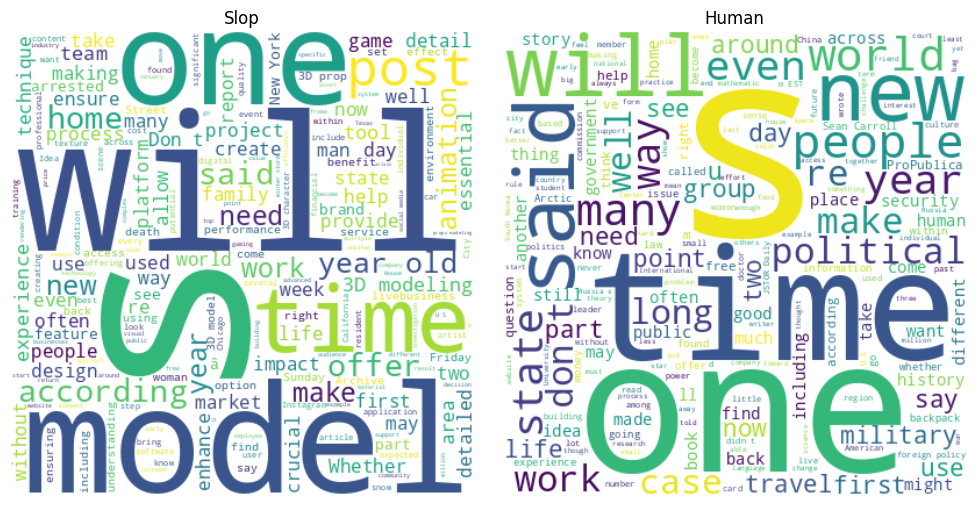

In [ ]:
wordcloud1 = WordCloud(width=400, height=400, background_color='white').generate(slop_text)
wordcloud2 = WordCloud(width=400, height=400, background_color='white').generate(human_text)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.title("Slop")
plt.subplot(1, 2, 2)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.title("Human")

plt.tight_layout()
plt.show()

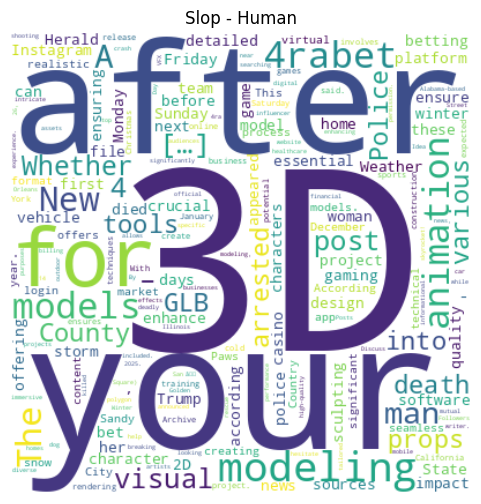

In [ ]:
counter1 = Counter("\n".join(slop_texts).split())
counter2 = Counter("\n".join(human_texts).split())

diff_counter = {word: max(count - counter2.get(word, 0), 0) for word, count in counter1.items()}

wordcloud_diff = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(diff_counter)

# Plot the word cloud
plt.figure(figsize=(6, 6))
plt.imshow(wordcloud_diff, interpolation='bilinear')
plt.axis("off")
plt.title("Slop - Human")
plt.show()

## Compare vocab frequency

Tried measuring vocab frecuency, still unconvincing.

In [ ]:
import json

In [ ]:
def compare_vocabs(text1, text2):
    t1_sents = tokenize_sentences(text1.lower())
    t2_sents = tokenize_sentences(text2.lower())

    t1_words, t2_words = [], []
    for sent in t1_sents:
        t1_words.extend(tokenize_words(sent))

    for sent in t2_sents:
        t2_words.extend(tokenize_words(sent))

    count_t1 = Counter(t1_words)
    count_t2 = Counter(t2_words)

    text1_text2_dict = {
        w: f"{count_t1[w]} - {count_t2[w]} = {count_t1[w] - count_t2[w]}"
        for w in (count_t1.keys() | count_t2.keys())
        if (count_t1[w] - count_t2[w]) != 0 and
            len(w) > 3
    }

    return text1_text2_dict

In [ ]:
slop_human = compare_vocabs(slop_text, human_text)

In [ ]:
print(json.dumps(dict(sorted(slop_human.items(), key=lambda x: int(x[1].split("=")[-1]), reverse=True)), indent=2))

{
  "modeling": "253 - 0 = 253",
  "your": "732 - 500 = 232",
  "after": "375 - 157 = 218",
  "models": "205 - 17 = 188",
  "animation": "175 - 2 = 173",
  "year": "293 - 122 = 171",
  "4rabet": "161 - 0 = 161",
  "county": "128 - 12 = 116",
  "police": "167 - 54 = 113",
  "project": "135 - 23 = 112",
  "news": "151 - 48 = 103",
  "according": "180 - 83 = 97",
  "quality": "102 - 8 = 94",
  "props": "89 - 0 = 89",
  "sunday": "98 - 11 = 87",
  "weather": "97 - 13 = 84",
  "game": "93 - 11 = 82",
  "california": "107 - 27 = 80",
  "into": "313 - 233 = 80",
  "winter": "87 - 7 = 80",
  "gaming": "79 - 0 = 79",
  "model": "105 - 26 = 79",
  "design": "98 - 19 = 79",
  "friday": "79 - 0 = 79",
  "visual": "87 - 10 = 77",
  "rescue": "79 - 2 = 77",
  "tools": "94 - 18 = 76",
  "process": "135 - 60 = 75",
  "software": "90 - 15 = 75",
  "2025": "98 - 26 = 72",
  "market": "88 - 17 = 71",
  "platform": "88 - 17 = 71",
  "monday": "82 - 13 = 69",
  "essential": "81 - 12 = 69",
  "arrested": "7

## Slop Words

Made a cool list from words in different articles of https://aiphrasefinder.com/ I've tried to validate them but only a handful looks good. The data is not super big so I might be missing stuff, but I think we can try with some of the most represented on the slop one.

In [ ]:
import re
from collections import Counter
import json

In [ ]:
with open("wordlist.json", 'r') as file:
    wordlist = json.load(file)

In [ ]:
def find_slop_words(wordlist, text):
  counts = {}
  for word in wordlist:
      wordcount = len(re.findall(rf'\b{re.escape(word)}\b', text))
      if wordcount > 0:
        counts[word] = wordcount
  return dict(sorted(counts.items(), key=lambda x: x[1], reverse=True))

In [ ]:
slop_words = find_slop_words(wordlist, "\n".join(slop_texts))
human_words = find_slop_words(wordlist, "\n".join(human_texts))

print(f"Slop\n{json.dumps(slop_words, indent=2)}")
print(f"Human\n{json.dumps(human_words, indent=2)}")

Slop
{
  "seamless": 47,
  "beyond": 26,
  "powerful": 25,
  "explore": 24,
  "elevate": 23,
  "pivotal": 18,
  "comprehensive": 17,
  "align": 14,
  "leverage": 13,
  "sophisticated": 12,
  "vibrant": 10,
  "meticulous": 9,
  "resonate": 8,
  "appealing": 8,
  "highlight": 8,
  "unprecedented": 8,
  "promising": 6,
  "underlying": 6,
  "ultimately": 6,
  "foundational": 6,
  "significantly enhance": 5,
  "remarkable": 5,
  "a testament to": 5,
  "integral": 4,
  "vast": 4,
  "harness": 4,
  "overwhelming": 4,
  "tailor": 4,
  "sustainable": 3,
  "to elevate": 3,
  "imaginative": 3,
  "multifaceted": 3,
  "the intricacies of": 3,
  "interplay": 3,
  "has emerged as a": 3,
  "measurable": 3,
  "transformative": 3,
  "bespoke": 2,
  "enrich": 2,
  "nuance": 2,
  "realm": 2,
  "delve": 2,
  "equip you with": 2,
  "embrace": 2,
  "calculate": 2,
  "has revolutionized": 2,
  "tapestry": 2,
  "beacon": 2,
  "cumulative": 2,
  "delve into": 2,
  "fulfilling": 1,
  "resilient": 1,
  "indeed": 

In [ ]:
all_keys = set(slop_words.keys()).union(human_words.keys())

slopword_dict = {}
for key in all_keys:
    value = slop_words.get(key, 0) - human_words.get(key, 0)
    if value > 0:
      slopword_dict[key] = value

slopword_dict = dict(sorted(slopword_dict.items(), key=lambda x: x[1], reverse=True))
slopword_dict

{'seamless': 45,
 'elevate': 22,
 'pivotal': 16,
 'align': 12,
 'leverage': 11,
 'meticulous': 9,
 'appealing': 7,
 'resonate': 7,
 'explore': 7,
 'sophisticated': 5,
 'significantly enhance': 5,
 'comprehensive': 4,
 'unprecedented': 4,
 'to elevate': 3,
 'imaginative': 3,
 'tailor': 3,
 'vibrant': 3,
 'has emerged as a': 3,
 'measurable': 3,
 'the intricacies of': 2,
 'has revolutionized': 2,
 'a testament to': 2,
 'equip you with': 2,
 'cumulative': 2,
 'bespoke': 2,
 'beacon': 2,
 'hustle and bustle of': 1,
 'gain valuable insights': 1,
 'ever-evolving': 1,
 'calculate': 1,
 'interplay': 1,
 'reimagine': 1,
 'harness': 1,
 'multifaceted': 1,
 'the core elements of': 1,
 'harness the power of': 1,
 'promising': 1,
 'transformative': 1,
 'plays a crucial role': 1,
 'fast-paced': 1,
 'left an indelible mark': 1,
 'nuance': 1,
 'tapestry': 1}

# Paragraph and Sentence Lengths

Here we try to see the frequency of syllables/word, words/sentence and sentence/paragraph. This is somewhat inspired by the Flesch–Kincaid readability test.
Still no convincing results, distributions look pretty similar and the only one that doesn't (sentences/paragraph) is probably related to bad parsing and text that is not relevant.

In [ ]:
import re
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def count_distributions(text):
    paragraphs = tokenize_paragraphs(text)
    sentences_per_paragraph = [len(tokenize_sentences(p)) for p in paragraphs]
    words_per_sentence = [len(tokenize_words(s)) for p in paragraphs for s in tokenize_sentences(p)]
    syllables_per_word = [
        count_syllables(word)
        for p in paragraphs
        for s in tokenize_sentences(p)
        for word in tokenize_words(s)
    ]
    return sentences_per_paragraph, words_per_sentence, syllables_per_word


sentences_paragraph_1, words_sentence_1, syllables_word_1 = count_distributions("\n".join(slop_texts))
sentences_paragraph_2, words_sentence_2, syllables_word_2 = count_distributions("\n".join(human_texts))

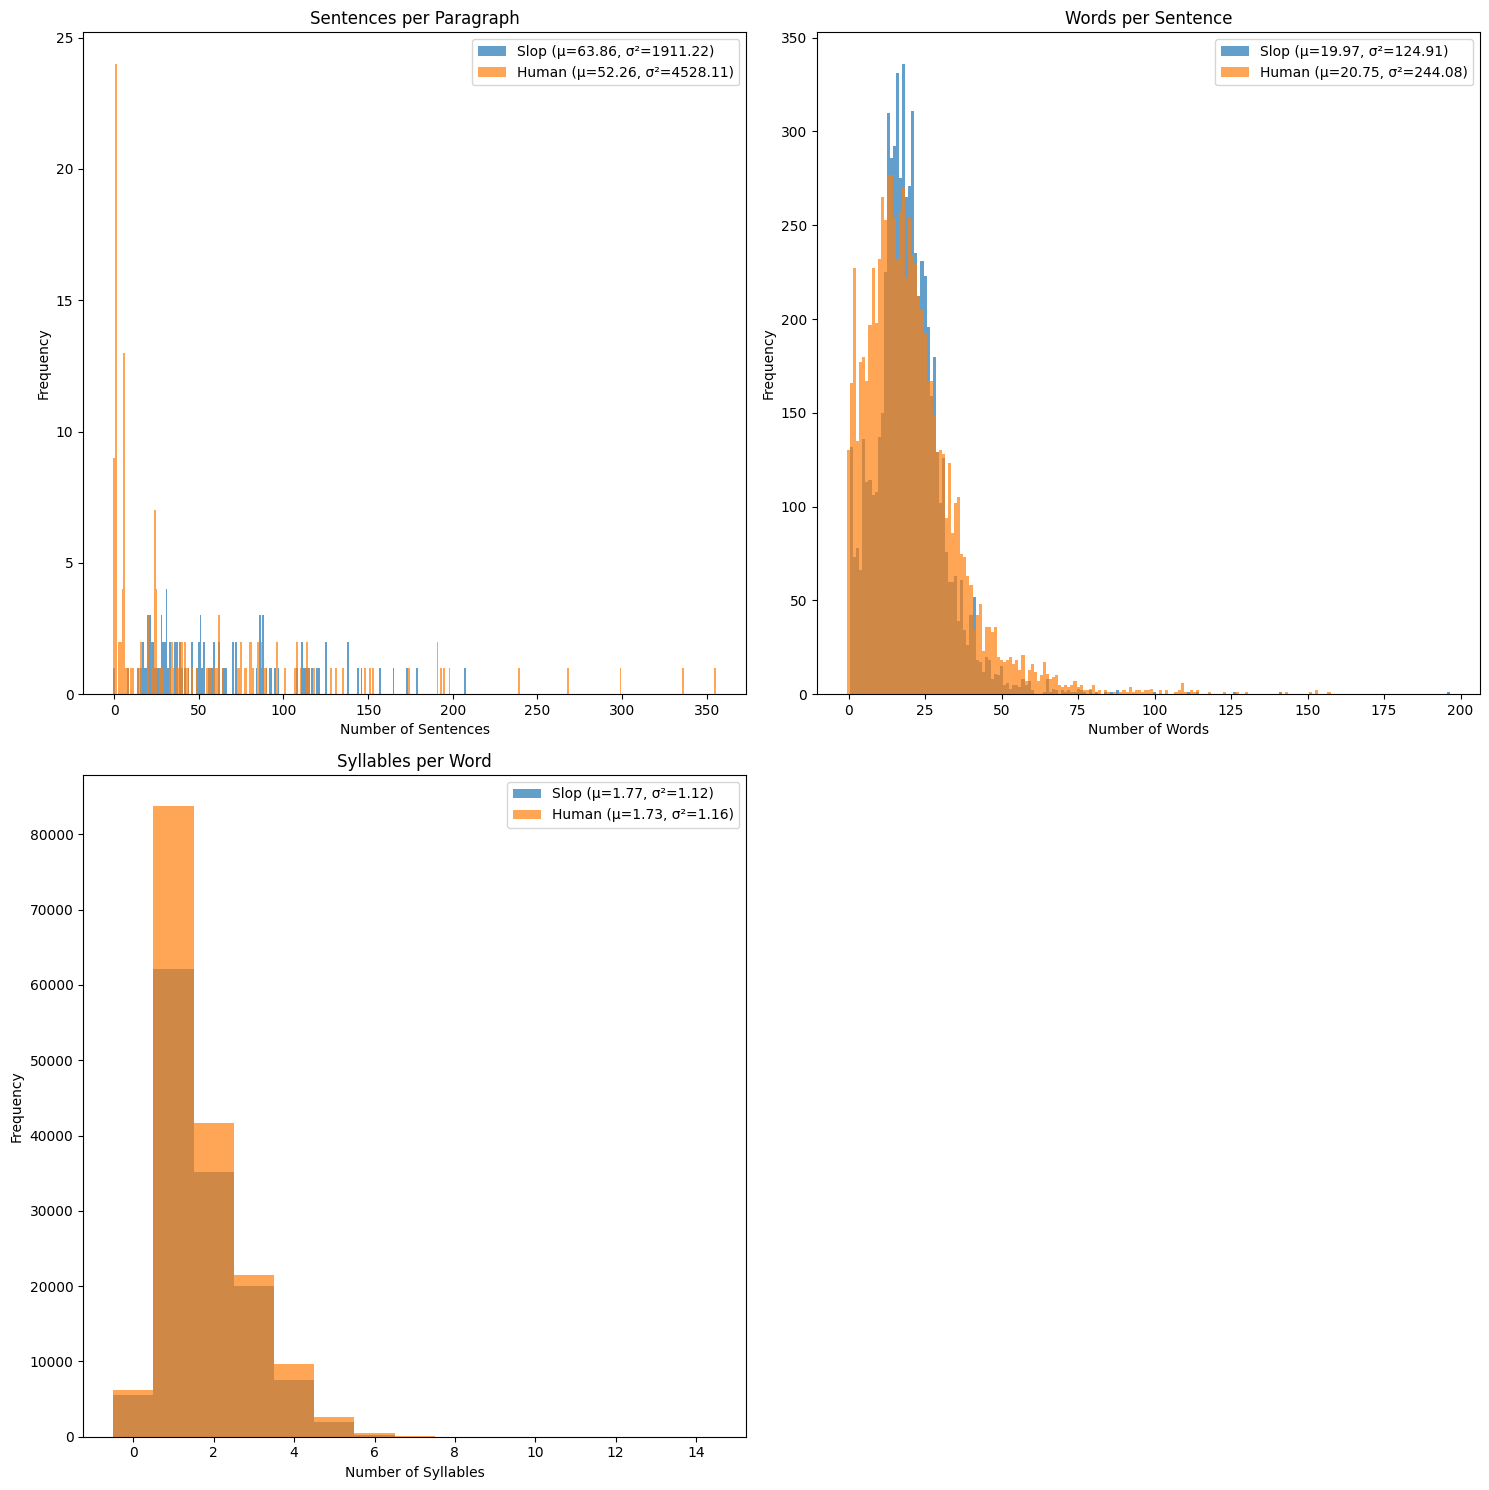

In [ ]:
def calculate_statistics(data, label):
    if data:
        mean = np.mean(data)
        variance = np.var(data)
        return f"{label} (μ={mean:.2f}, σ²={variance:.2f})"
    return label

plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
bins = np.arange(max(max(sentences_paragraph_1, default=0), max(sentences_paragraph_2, default=0)) + 1.5) - 0.5
plt.hist(sentences_paragraph_1, bins, alpha=0.7, label=calculate_statistics(sentences_paragraph_1, "Slop"))
plt.hist(sentences_paragraph_2, bins, alpha=0.7, label=calculate_statistics(sentences_paragraph_2, "Human"))
plt.title("Sentences per Paragraph")
plt.xlabel("Number of Sentences")
plt.ylabel("Frequency")
plt.legend()

plt.subplot(2, 2, 2)
bins = np.arange(max(max(words_sentence_1, default=0), max(words_sentence_2, default=0)) + 1.5) - 0.5
plt.hist(words_sentence_1, bins, alpha=0.7, label=calculate_statistics(words_sentence_1, "Slop"))
plt.hist(words_sentence_2, bins, alpha=0.7, label=calculate_statistics(words_sentence_2, "Human"))
plt.title("Words per Sentence")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.legend()

plt.subplot(2, 2, 3)
bins = np.arange(max(max(syllables_word_1, default=0), max(syllables_word_2, default=0)) + 1.5) - 0.5
plt.hist(syllables_word_1, bins, alpha=0.7, label=calculate_statistics(syllables_word_1, "Slop"))
plt.hist(syllables_word_2, bins, alpha=0.7, label=calculate_statistics(syllables_word_2, "Human"))
plt.title("Syllables per Word")
plt.xlabel("Number of Syllables")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
def filter_paragraphs_by_sentence_count(text, min_words=20, max_words=160):
    res = []
    paragraphs = tokenize_paragraphs(text)
    for paragraph in paragraphs:
        sentence_count = len(tokenize_sentences(paragraph))
        if sentence_count > max_words or sentence_count < min_words:
            res.append(paragraph)
    return res

for i in sorted(filter_paragraphs_by_sentence_count("\n".join(human_texts)), key=len):
    if i.replace("Any", "").replace(".","").strip() == "":
        continue
    for j in i.split(". "):
        print(repr(j))
    print("-"*50)

' '
' Outraged by the Jan'
'6 Capitol riot, a wilderness survival trainer spent years undercover climbing the ranks of right-wing militias'
'\n\n'
--------------------------------------------------
'Rebecca studied journalism and history at Boston University'
'She has invested in Ethereum'
'Elon Musk agrees that we’ve exhausted AI training data CES 2025 was full of IRL AI slop Halliday’s $489 smart glasses beam a tiny screen to your eye Mastodon CEO calls Meta’s moderation changes ‘deeply troubling,’ warns users cross-posting from Threads Gamers can’t fathom how 6x CEO Elon Musk found time to best Diablo IV Ukrainian hackers take credit for hacking Russian ISP that wiped out servers and caused internet outages Edtech giant PowerSchool says hackers accessed personal data of students and teachers Subscribe for the industry’s biggest tech news Every weekday and Sunday, you can get the best of TechCrunch’s coverage'
"TechCrunch's AI experts cover the latest news in the fast-moving field"
'

In [ ]:
for i in sorted(filter_paragraphs_by_sentence_count("\n".join(slop_texts)), key=len):
    if i.replace("Any", "").replace(".","").strip() == "":
        continue
    for j in i.split(". "):
        print(repr(j))
    print("-"*50)

'Finding the right dentist is key to maintaining excellent oral health'
'Here’s a quick guide to help you make an informed decision'
'Routine checkups prevent cavities, gum issues, and more'
'If you’re looking for adentist in North Kildonan, select one prioritizing preventive care and personalized treatments'
'Explore clinics online and prioritize those offering comprehensive care'
'A reliabledentist near youensures quality treatment and peace of mind'
'For outstanding dental care in North Kildonan, visit All Seasons Dental Clinic'
'Our team provides exceptional service tailored to your needs.Book your appointmenttoday!\n'
--------------------------------------------------
'Inflammation is a natural process of healing damaged tissues in and throughout your body'
'If your back is constantly getting inflamed, then there is an underlying factor at play that is causing continuous or repetitive damage to your lower back'
'This damage could be to the discs of the spine, the facet joints, or 

# Pos Tagging

I wanted to check if any text is more complex than the other syntactically. There are really cool ideas around but the only one reasonable enough for this use-case is using pos tag and then doing a proxy with regex.

## Pos Trigram Perplexity

Inspired by this cool paper: https://www.christianbentz.de/MLC2018/Prince_Demberg.pdf

In theory the pos trigram perplexity should correlate with syntactic complexity. Still no good results to discriminate, but I'm not 100% sure my implementation is as intended.

In [ ]:
!pip install nltk

In [ ]:
import nltk
from nltk import pos_tag
import math
from collections import Counter

nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [ ]:
def trigram_perplexity(text, smoothing=1):
    """
    Takes raw text, POS-tags it, then computes trigram perplexity.
    """
    # Tokenize and POS tag
    tokens = tokenize_words(text)
    pos_tags = [tag for (_, tag) in nltk.pos_tag(tokens)]

    bigram_counts = Counter()
    trigram_counts = Counter()

    for i in range(2, len(pos_tags)):
        bigram = (pos_tags[i-2], pos_tags[i-1])
        trigram = (pos_tags[i-2], pos_tags[i-1], pos_tags[i])
        bigram_counts[bigram] += 1
        trigram_counts[trigram] += 1

    vocab_size = len(set(pos_tags))

    log_prob_sum = 0.0
    count = 0
    for i in range(2, len(pos_tags)):
        bigram = (pos_tags[i-2], pos_tags[i-1])
        trigram = (pos_tags[i-2], pos_tags[i-1], pos_tags[i])
        p = (trigram_counts[trigram] + smoothing) / \
            (bigram_counts[bigram] + smoothing * vocab_size)
        log_prob_sum += math.log2(p)
        count += 1

    if count==0:
        return 0

    return 2 ** (-log_prob_sum / count) if count else float('inf')


for i in [
          "The cat sat on the mat.",
          "We enjoy playing chess in the park.",
          "Despite the rain, the concert continued outdoors.",
          "Quickly he realized his grave mistake.",
          "John swam across the river to reach safety.",
          "Eagerly awaiting the news, she paced the floor.",
          "They delivered the package earlier than expected.",
          "When Sarah arrived, the meeting had already started.",
          "He who hesitates is often lost.",
          "While jogging at dawn, I spotted a rare bird.",
        ]:
  print(trigram_perplexity(i))

2.4999999999999996
3.5
3.190802844740424
3.0000000000000004
3.4999999999999996
3.4999999999999996
4.0
4.0
3.0000000000000004
4.0


In [ ]:
perplexities_text1 = [trigram_perplexity(i) for i in tokenize_sentences(slop_text)]
perplexities_text2 = [trigram_perplexity(i) for i in tokenize_sentences(human_text)]

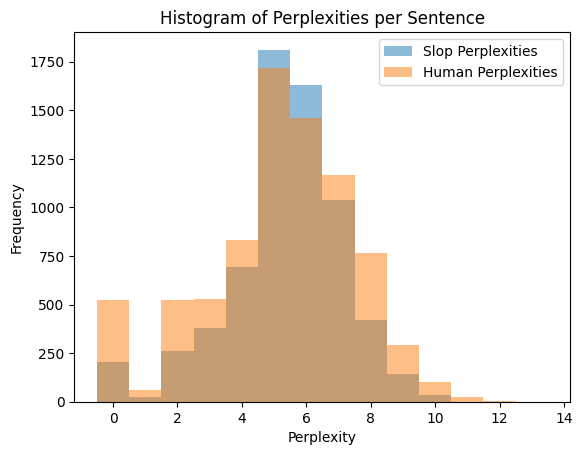

In [ ]:
bins = np.arange(
    max(max(perplexities_text1, default=0), max(perplexities_text2, default=0)) + 1.5
) - 0.5

plt.hist(perplexities_text1, bins=bins, alpha=0.5, label="Slop Perplexities")
plt.hist(perplexities_text2, bins=bins, alpha=0.5, label="Human Perplexities")

plt.title("Histogram of Perplexities per Sentence")
plt.xlabel("Perplexity")
plt.ylabel("Frequency")
plt.legend()

plt.show()

## Number of Pos tags

Ok, some interesting stuff, some pos tag frequency seems to be different in both sets. Cannot really say way without speculating too much, but it could be interesting as a feature with some proxy regex. We will validate with the linear model.

In [ ]:
from itertools import chain
import json

In [ ]:
tokens_text1 = list(chain.from_iterable(tokenize_words(sentence) for sentence in tokenize_sentences(slop_text)))
tokens_text2 = list(chain.from_iterable(tokenize_words(sentence) for sentence in tokenize_sentences(human_text)))

tags_text1 = pos_tag(tokens_text1)
tags_text2 = pos_tag(tokens_text2)

pos_counts_text1 = {}
pos_counts_text2 = {}

for _, tag in tags_text1:
    pos_counts_text1[tag] = pos_counts_text1.get(tag, 0) + 1

for _, tag in tags_text2:
    pos_counts_text2[tag] = pos_counts_text2.get(tag, 0) + 1

pos_counts_text1 = {k: v/len(tokens_text1) for k,v in pos_counts_text1.items()}
pos_counts_text2 = {k: v/len(tokens_text2) for k,v in pos_counts_text2.items()}

all_pos_tags = set(pos_counts_text1.keys()).union(set(pos_counts_text2.keys()))

pos_tags = list(all_pos_tags)
counts_text1 = [pos_counts_text1.get(tag, 0) for tag in pos_tags]
counts_text2 = [pos_counts_text2.get(tag, 0) for tag in pos_tags]

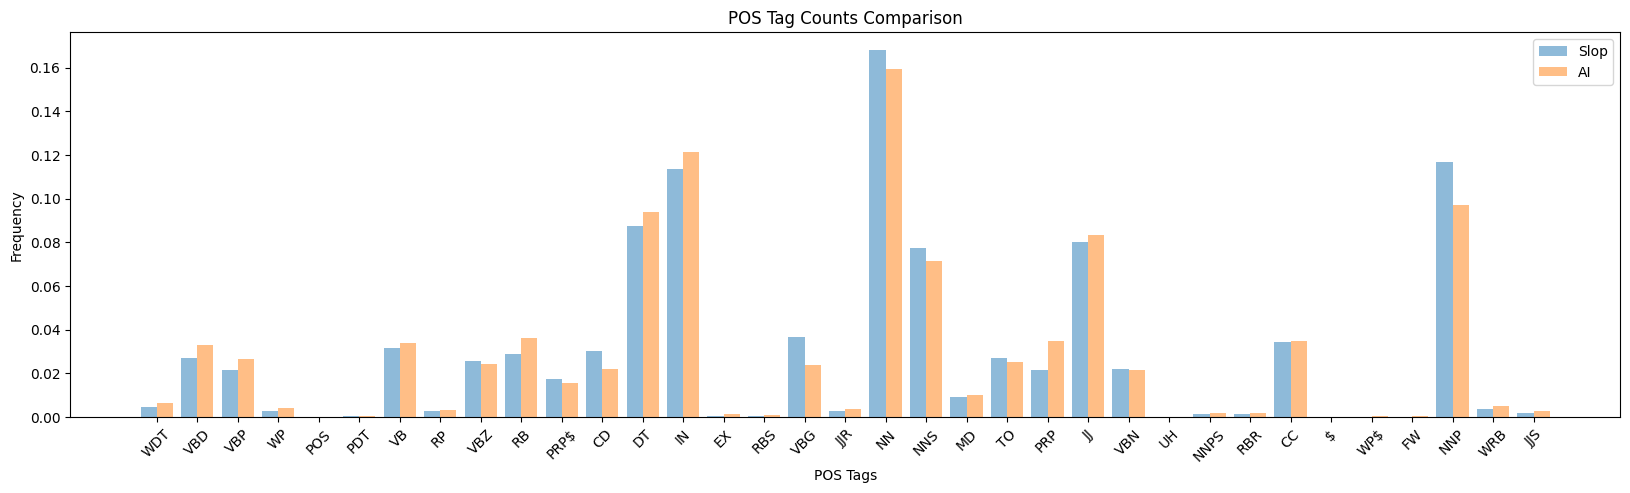

In [ ]:
x = range(len(pos_tags))
bar_width = 0.4

plt.figure(figsize=(20, 5))

plt.bar([i - bar_width/2 for i in x], counts_text1, bar_width, alpha=0.5, label="Slop")
plt.bar([i + bar_width/2 for i in x], counts_text2, bar_width, alpha=0.5, label="AI")

plt.xticks(x, pos_tags, rotation=45)
plt.title("POS Tag Counts Comparison")
plt.xlabel("POS Tags")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [ ]:
pos_counts_diff = {
    tag: pos_counts_text1.get(tag, 0) - pos_counts_text2.get(tag, 0)
    for tag in set(pos_counts_text1.keys()).union(pos_counts_text2.keys())
}

print(json.dumps(dict(sorted(pos_counts_diff.items(), key=lambda item: item[1], reverse=True)), indent=2))

{
  "NNP": 0.019709729190598158,
  "VBG": 0.012864219827255864,
  "NN": 0.008682004845098956,
  "CD": 0.008286336510273044,
  "NNS": 0.005624739612317853,
  "PRP$": 0.001791036633628406,
  "TO": 0.0013914794752457917,
  "VBZ": 0.0013252432269660747,
  "VBN": 0.00047753999788649124,
  "$": -7.50797305344171e-06,
  "UH": -2.25903605953896e-05,
  "POS": -4.366583829307796e-05,
  "PDT": -0.00014268470873292474,
  "RBS": -0.00015302312327657543,
  "WP$": -0.00020031670028063613,
  "CC": -0.00024519888946940294,
  "NNPS": -0.0002515104622359064,
  "FW": -0.00029054525979206564,
  "RBR": -0.00030120261140225714,
  "RP": -0.00042767542819713766,
  "MD": -0.0005365809841351207,
  "JJS": -0.0007842243912461943,
  "JJR": -0.0008634169011457961,
  "EX": -0.0009228428114402487,
  "WP": -0.0011553109402479022,
  "WRB": -0.0013833473526238304,
  "WDT": -0.001980536831884627,
  "VB": -0.0024225707450114403,
  "JJ": -0.003013701328919524,
  "VBP": -0.004953979968287708,
  "VBD": -0.005603120696398199,


# Symbols

Some people claim that ai generated text uses weird combination of symbols. It seems like it does, also some symbols like em-dashes are more featured in non-slop texts. This might be a bit biased as I chose mostly articles for the dataset so it might be stylistical preference, but I will still add it as I think is interesting.

Apostrophes (' and ’)

In [ ]:
print("slop text:", sum([1 for i in tokenize_sentences(slop_text) if "'" in i and "’" in i])/len(slop_text))
print("human text:", sum([1 for i in tokenize_sentences(human_text) if "'" in i and "’" in i])/len(human_text))

slop text: 3.249934399472307e-05
human text: 1.953582870985387e-06


Symbols

In [ ]:
for i in ["-", "—", '"', "“", ","]:
  print(f"Instances of {i} in text")
  print("slop text:", slop_text.count(i))
  print("human text:", human_text.count(i))

Instances of - in text
slop text: 1896
human text: 1907
Instances of — in text
slop text: 181
human text: 500
Instances of " in text
slop text: 289
human text: 2
Instances of “ in text
slop text: 322
human text: 1198
Instances of , in text
slop text: 7344
human text: 10083


# Ascending tricolons

This idea (and some others) was inspired by https://www.reddit.com/r/ApplyingToCollege/comments/1h0vhlq/in_the_past_three_days_ive_reviewed_over_100/

It was interesting but doesn't really hold, I think it should work more on ai-generated essays so I didn't add it as a feature.

In [ ]:
def find_ascending_tricolons(text):
    pattern = re.compile(r"([^,]+), ([^,]+) and ([^,]+)")
    candidates = pattern.findall(text)

    results = []
    for x, y, z in candidates:
        x_str, y_str, z_str = x.strip(), y.strip(), z.strip()
        if (len(y_str) >= len(x_str) and len(z_str) > len(y_str) and
          len(x_str)<60 and len(y_str)<60 and len(z_str)<60):
            results.append((x, y, z))

    return results

In [ ]:
for i in [find_ascending_tricolons(j) for j in tokenize_sentences(slop_text+"\n"+human_text)]:
    if i!=[]:
        print(i)

[(' remains \u2063secure', 'cemented by years of unforgettable music', 'a loyal fanbase that eagerly awaits their return.')]
[(' not\u200d replace', 'human creativity', 'critical thinking.')]
[(' Ralph Fiennes', 'Cynthia Erivo', 'Kate Winslet are up for awards'), (' Nicole Kidman', 'Angelina Jolie', 'Colman Domingo.')]
[(' including voting', 'Hollywood sex scandals', 'Timothee Chalamet ’s facial hair.')]
[(' who performs as the drag queen', 'won the first series of RuPaul’s Drag Race UK', 'came third on the 2023 edition of Dancing On Ice.')]
[(' Arizona', 'as family', 'friends honor her life.')]
[(' for multiple charges', 'including drug trafficking', 'promoting prison contraband.')]
[(' who performs as the drag queen', 'won the first series of RuPaul’s Drag Race UK', 'came third on the 2023 edition of Dancing On Ice.')]
[(' Wyoming', 'and Washington receive their BEAD funding', 'additional federal funds towards broadband expansion')]
[(' 26', 'an architect', 'interior designer')]
[(' 

In [ ]:
print("slop text:", sum([len(find_ascending_tricolons(i)) for i in tokenize_sentences(slop_text)]))
print("human text:", sum([len(find_ascending_tricolons(i)) for i in tokenize_sentences(human_text)]))

slop text: 68
human text: 84


# Common Phrases

Also inspired by https://www.reddit.com/r/ApplyingToCollege/comments/1h0vhlq/in_the_past_three_days_ive_reviewed_over_100/

Doesn't really hold, we should account for variation but honestly I'm not super convinced by this.

In [ ]:
def find_that_is_not_but(text):
    pattern = re.compile(r"that is not")
    return pattern.findall(text)

def find_as_i_will(text):
    pattern = re.compile(r"([^,]+)I will ([^,]+)")
    return pattern.findall(text)

def find_is_not_about(text):
    pattern = re.compile(r"([^,]+) is not about ([^,]+)")
    return pattern.findall(text)

In [ ]:
for fun in [find_that_is_not_but, find_as_i_will, find_is_not_about]:
    print(fun)
    res_slop = fun(slop_text)
    res_human = fun(human_text)
    print(f"slop_text: {len(res_slop)} ({res_slop})")
    print(f"slop_text: {len(res_human)} ({res_human})")
    print()

<function find_that_is_not_but at 0x7a067bb417e0>
slop_text: 1 (['that is not'])
slop_text: 3 (['that is not', 'that is not', 'that is not'])

<function find_as_i_will at 0x7a067bb43d00>
slop_text: 2 ([('000 comments on different social media pages including theNew YorkersandBukharian CommunityInstagram pages. “', 'never eat there again and after this'), (' describe them and let our AI take the wheel. Looking for a vibe that youâ\x80\x99re not entirely sure how to capture with words? Upload an image and our A', 'find creators with matching aesthetics. â\x80\x8d Search')])
slop_text: 3 ([(' and ', 'stand with you. That'), (' ', 'always wonder whether the explanation that I have heard is reality or merely a reflection of reality'), (' to make amends in! “', 'live in the Past')])

<function find_is_not_about at 0x7a067bb43eb0>
slop_text: 0 ([])
slop_text: 0 ([])



# Regression

The idea here is to implement a super easy regression model, and train with our dataset.
I know I should use a logistic regression model and do a train/val/test split and add more training data but think of this more on us finding a good index with the features we got that we can simply implement than doing a real model. The idea here is to do something that works fast.

In [ ]:
import pandas as pd
from random import shuffle
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, f1_score, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Data

In [ ]:
def split_text_into_substrings(row, num_split=10):
    text = row["text"]
    substrings = [text[i:i+len(text) // num_split] for i in range(0, len(text), len(text) // num_split)]
    substrings = substrings[:num_split] if len(substrings) > num_split else substrings
    return [{"text": substr, "label": row["label"]} for substr in substrings]

data = df[["Content", "Type"]].rename(columns={"Content": "text", "Type": "label"})
data = [split for _, row in data.iterrows() for split in split_text_into_substrings(row, num_split=5)]
data = pd.DataFrame(data)

data

,text,label
0,A devastating incident unfolded on friday in T...,slop
1,bathing and washing are popular tourist activ...,slop
2,"cruel training methods frequently employed, i...",slop
3,"closed. García,​ a resident of Valladolid, Spa...",slop
4,"ana García,” albares stated. This ‌tragic even...",slop
...,...,...
995,Education technology giant PowerSchool has tol...,human
996,"nformation system, PowerSchool SIS, which scho...",human
997,vices as normal to our customers.” The nature ...,human
998,l collects this highly sensitive information u...,human


## Training

In [ ]:
import re

In [ ]:
def extract_features(text):
    features = {
        "contains_dash": len(re.findall(r'-', text)),
        "contains_em_dash": len(re.findall(r'—', text)),
        "contains_double_quote": len(re.findall(r'"', text)),
        "contains_smart_double_quote": len(re.findall(r'[“”]', text)),
        "contains_single_quote_pair": len(re.findall(r"'", text)) > 0 and len(re.findall(r'’', text)) > 0,
        "contains_seamless": len(re.findall(r'\bseamless\b', text, flags=re.IGNORECASE)),
        "contains_elevate": len(re.findall(r'\belevate\b', text, flags=re.IGNORECASE)),
        "contains_pivotal": len(re.findall(r'\bpivotal\b', text, flags=re.IGNORECASE)),
        "contains_align": len(re.findall(r'\balign\b', text, flags=re.IGNORECASE)),
        "contains_leverage": len(re.findall(r'\bleverage\b', text, flags=re.IGNORECASE)),
        "number_postags_vbg": len(re.findall(r'\b\w+ing\b', text)),
        "number_postags_prp": len(re.findall(r'\b(?:I|me|you|he|she|it|we|they|him|her|us|them|myself|yourself|herself|himself|itself|ourselves|themselves)\b', text)),
        "number_postags_rb": len(re.findall(r'\b(\w+ly|here|there|now|then|soon|always|never|often|sometimes|everywhere|nowhere|somewhere|very|too|quite|almost|rather|fast|hard|late|near|far|straight|well)\b', text)),
    }
    return features


feature_data = data['text'].apply(extract_features)
feature_df = pd.DataFrame(list(feature_data))

feature_df['label'] = data['label']

feature_df['label'] = feature_df['label'].map({'slop': 0, 'human': 1})  # Adjust as per labels

X = feature_df.drop(columns=['label'])
y = feature_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

## Evaluation

The results don't look too bad but the dataset is not super big. I think the weight factor of each feature is interesting.

Mean Squared Error: 0.18887567694123886
F1-Score: 0.72


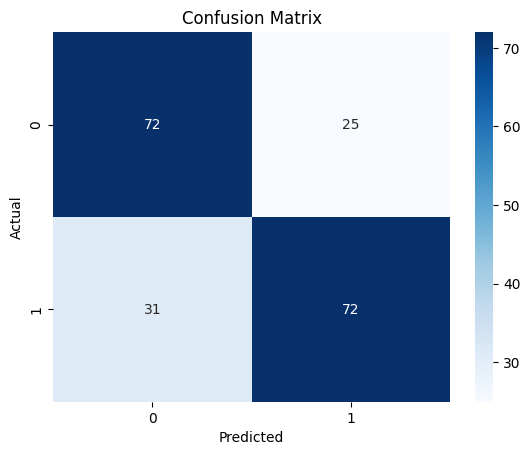

In [ ]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

threshold = 0.5 #3
y_pred_binary = (y_pred >= threshold).astype(int)

f1 = f1_score(y_test, y_pred_binary)
print(f"F1-Score: {f1}")

cm = confusion_matrix(y_test, y_pred_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Feature Importance:
                        Feature  Coefficient  Absolute_Coefficient
4    contains_single_quote_pair    -0.246752              0.246752
5             contains_seamless    -0.207119              0.207119
2         contains_double_quote    -0.083635              0.083635
7              contains_pivotal    -0.064158              0.064158
8                contains_align     0.057994              0.057994
1              contains_em_dash     0.041175              0.041175
9             contains_leverage     0.023982              0.023982
12            number_postags_rb     0.019532              0.019532
6              contains_elevate    -0.019240              0.019240
10           number_postags_vbg    -0.012971              0.012971
3   contains_smart_double_quote     0.007119              0.007119
11           number_postags_prp     0.005763              0.005763
0                 contains_dash     0.003224              0.003224


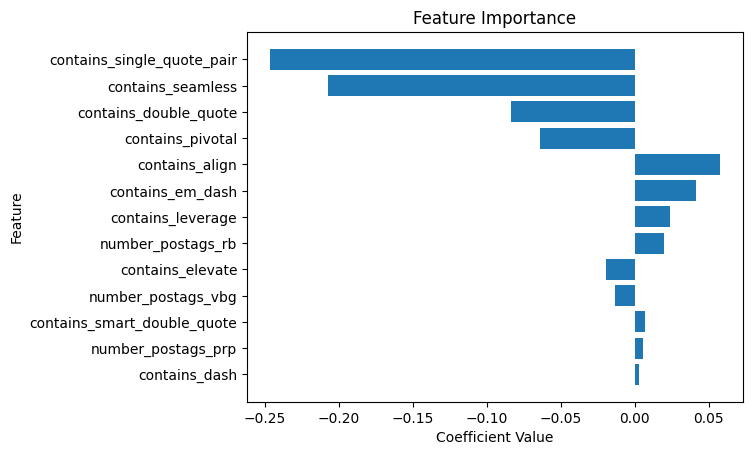

In [ ]:
feature_names = X.columns
coefficients = model.coef_

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

feature_importance['Absolute_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Absolute_Coefficient', ascending=False)

print("Feature Importance:")
print(feature_importance)

plt.barh(feature_importance['Feature'], feature_importance['Coefficient'])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

## Custom Model

Here I implement the model by myself so I can replicate in js
The results look good so I just need to turn this into the chrome extension.

In [ ]:
print(f"{list(model.coef_)}, {model.intercept_}")

[0.003224097730849752, 0.041174883598401546, -0.08363519093665123, 0.007118889863322623, -0.24675198467522655, -0.20711948433976712, -0.01923992845820089, -0.06415759681531612, 0.057993917413981785, 0.023981672786734798, -0.012971271988087783, 0.005762784684722451, 0.019531599440375018], 0.4748231644400827


In [ ]:
def extract_features(text):
    return {
        "contains_dash": len(re.findall(r'-', text)),
        "contains_em_dash": len(re.findall(r'—', text)),
        "contains_double_quote": len(re.findall(r'"', text)),
        "contains_smart_double_quote": len(re.findall(r'[“”]', text)),
        "contains_single_quote_pair": 1 if (re.findall(r"'", text) and re.findall(r'’', text)) else 0,
        "contains_seamless": len(re.findall(r'\bseamless\b', text, flags=re.IGNORECASE)),
        "contains_elevate": len(re.findall(r'\belevate\b', text, flags=re.IGNORECASE)),
        "contains_pivotal": len(re.findall(r'\bpivotal\b', text, flags=re.IGNORECASE)),
        "contains_align": len(re.findall(r'\balign\b', text, flags=re.IGNORECASE)),
        "contains_leverage": len(re.findall(r'\bleverage\b', text, flags=re.IGNORECASE)),
        "number_postags_vbg": len(re.findall(r'\b\w+ing\b', text)),
        "number_postags_prp": len(re.findall(r'\b(?:I|me|you|he|she|it|we|they|him|her|us|them|myself|yourself|herself|himself|itself|ourselves|themselves)\b', text)),
        "number_postags_rb": len(re.findall(r'\b(\w+ly|here|there|now|then|soon|always|never|often|sometimes|everywhere|nowhere|somewhere|very|too|quite|almost|rather|fast|hard|late|near|far|straight|well)\b', text)),
    }

weights, intercept = [0.003224097730849752, 0.041174883598401546, -0.08363519093665123, 0.007118889863322623, -0.24675198467522655, -0.20711948433976712, -0.01923992845820089, -0.06415759681531612, 0.057993917413981785, 0.023981672786734798, -0.012971271988087783, 0.005762784684722451, 0.019531599440375018], 0.4748231644400827

def predict(text, threshold=0.5):
    feats = extract_features(text)
    keys = feats.keys()

    score = intercept
    for i, k in enumerate(keys):
        score += feats[k] * weights[i]

    print(score)

    return 1 if score >= threshold else 0

0.5042885719800814
0.5773883855682139
1.4895021970911744
0.47414128863419047
0.4509950323349864
0.7277856362503872
0.9040570358379334
0.5084562711296743
0.4552990039620079
-0.06508331800740855
0.5500468140107814
0.2019536325212698
0.5486124543456541
0.5392583551703047
1.1784642287183513
0.7506792105758392
-0.17828820999079656
0.746521467108211
0.6042276554127305
0.5515216818308705
0.4871462765770924
0.37856332015093896
0.4424696759281066
0.5172598439681692
0.2413892800389215
0.5416016309324574
0.4552990039620079
0.12109911026019685
1.133589296898157
0.6918917743386479
0.4749725473565694
0.6094106643722785
0.6712805117078776
0.48892467168929926
0.5295829561051789
-0.7733350607333606
0.8089077029205556
0.7726780354494627
0.7829490132956468
-0.768690219061545
0.5042554357511743
0.10209885384146941
0.4531977025299867
0.24554616766140916
0.46366753849010073
0.19159339598275682
0.29629821969883235
0.8824753817689204
0.19013857747705276
0.48852453709334676
0.6841663086398698
1.141958735693412

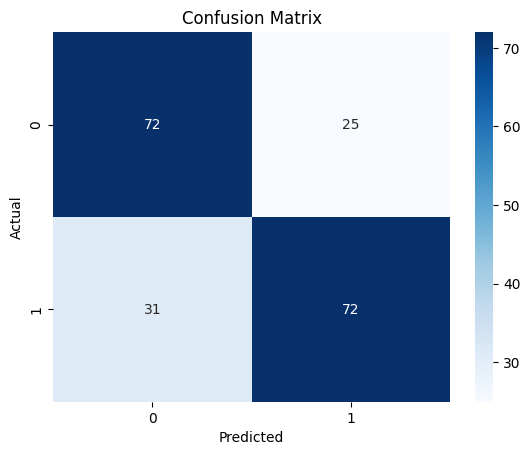

In [ ]:
_, X_test, _, y_test = train_test_split(data[["text"]], data["label"].apply(lambda x: 0 if x == 'slop' else 1), test_size=0.2, random_state=42)
y_pred = X_test["text"].apply(predict)
#y_pred = predict_df(X_test, model.coef_, model.intercept_)["Predicted Class"]


mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

f1 = f1_score(y_test, y_pred)
print(f"F1-Score: {f1}")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()